In [1]:
import os
import glob
import numpy as np
import cv2
from sklearn.utils import shuffle
import matplotlib.image as img
import time
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Changing Name of Dataset

In [2]:
def rename(file_path, classes, set_name=None):
    for file in classes:
        old_path = os.path.join(file_path, file) + '/'
        path = os.path.join(file_path, file)
        for index, name in enumerate(os.listdir(old_path)):
            path_new_name = old_path + set_name + file + '.' + str(index) + '.jpeg'
            path_old_name = old_path + name
            os.rename(path_old_name, path_new_name)

classes = ['NORMAL', 'PNEUMONIA']

train_path = 'chest_xray/train/'
test_path = 'chest_xray/test/'
val_path = 'chest_xray/val/'
checkpoint_dir = "models/"

# # rename(val_path, classes, set_name='val.')
# rename(test_path, classes, set_name='test.')
# rename(train_path, classes, set_name='train.')

# load and show data

Reading file chest_xray/train/ image: 
Loading NORMAL files (Index: 0)
Loading PNEUMONIA files (Index: 1)

Num example: 5216

Reading file chest_xray/test/ image: 
Loading NORMAL files (Index: 0)
Loading PNEUMONIA files (Index: 1)

Num example: 624

Reading file chest_xray/val/ image: 
Loading NORMAL files (Index: 0)
Loading PNEUMONIA files (Index: 1)

Num example: 16



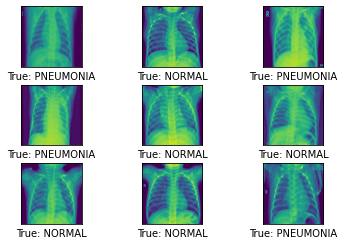

In [3]:
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import preprocessing

from tensorflow.python.framework import ops
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()

num_channels = 1

# image dimensions (only squares for now)
img_size = 224

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['NORMAL', 'PNEUMONIA']
num_classes = len(classes)

# batch size
batch_size = 128

# validation split
validation_size = 0.16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_data = preprocessing.read_model_sets(train_path, img_size, classes)
test_data = preprocessing.read_model_sets(test_path, img_size, classes)
val_data = preprocessing.read_model_sets(val_path, img_size, classes)

def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = images[i]
        ax.imshow(image)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Get some random images and their labels from the train, test, valid set.
train_images, train_cls_true  = train_data.train.images, train_data.train.cls
val_images, val_cls_true = val_data.train.images, val_data.train.cls
test_images, test_cls_true = test_data.train.images, test_data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=train_images, cls_true=train_cls_true)

In [4]:
train_labels  = train_cls_true.copy()
test_labels = test_cls_true.copy()
val_labels = val_cls_true.copy()

In [ ]:
from tensorflow.python.framework import ops
import warnings, os
import numpy as np
from datetime import datetime
from tensorflow.contrib.layers import dropout
from tensorflow.contrib.layers import flatten


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

ops.reset_default_graph()
reset_graph()

'''==================================================================='''

len_train_images = len(train_images)
len_test_images = len(test_images)
len_val_images = len(val_images)

'''PNEUMONIA: 1, NORMAL: 0'''
def convert(objects):
    n_objects = []
    for i in range(len(objects)):
        if objects[i] == 'PNEUMONIA':
            n_objects.append(1)
        else:
            n_objects.append(0)
    return n_objects
            
train_images = train_images.reshape(len_train_images, 224, 224, 1)
train_labels1 = convert(train_labels)

test_images = test_images.reshape(len_test_images, 224, 224, 1)
test_labels1 = convert(test_labels)

val_images = val_images.reshape(len_val_images, 224, 224, 1)
val_labels = convert(val_labels)

def one_hot(labels):
    y_one_hot = np.zeros((len(labels), 10))
    for i, j in enumerate(labels):
        y_one_hot[i][j] = 1
    return y_one_hot

train_labels = one_hot(train_labels1)
test_labels = one_hot(test_labels1)
val_labels = one_hot(val_labels)

print("Input test 0: {}\n".format(test_labels[0]))
print("Training Set:   {} samples".format(len(train_images)))
print("Validation Set: {} samples".format(len(val_images)))
print("Test Set:       {} samples\n".format(len(test_images)))

'''================================================================================'''
n_hidden1 = 400
n_hidden2 = 300
n_hidden3 = 200
n_hidden4 = 100
n_outputs = 10

n_epochs = 20
batch_size = 50

n_batches = len_train_images // batch_size

MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
DROPOUT_KEEP_PROB = 0.5
FC_HIDDEN_SIZE = 4096
K_BIAS = 2
N_DEPTH_RADIUS = 5
ALPHA = 1e-4
BETA = 0.75

'''prepreparing==================================================================='''
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name='X')
y = tf.placeholder(tf.int32, shape=(None, 10), name='y')

unit_epoch = tf.placeholder(dtype=tf.float32, shape=None)

is_training = tf.placeholder(tf.bool, shape=(), name='is_training')
keep_prob = 0.5

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index) 
    indices = np.random.randint(len_train_images, size=batch_size) 
    X_batch = train_images[indices]
    y_batch = train_labels[indices]
    return X_batch, y_batch


def learning_schedule(epoch):
    return 1 / ((epoch+1) * 100)

def batch_forward(X, eps=1e-5, momentum=0.9, mode="train"):
    mean, variance = tf.math.reduce_mean(tf.cast(train_images, dtype=tf.float32)), tf.math.reduce_variance(tf.cast(train_labels, dtype=tf.float32)) 
    gamma = tf.sqrt(variance)
    beta = mean

    X = tf.cast(X, dtype=tf.float32)
    N, D = 32, 32

    running_mean, running_variance = tf.zeros(D, dtype=X.dtype), tf.zeros(D, dtype=X.dtype)
    z_out, cache = None, None

    if mode == 'train':
      sample_mean, sample_variance = tf.math.reduce_mean(X, axis=0), tf.math.reduce_variance(X, axis=0)
    
      X_norm = (X - sample_mean) / tf.sqrt(sample_variance + eps)
      z_out = (gamma * X_norm) + beta

#       running_mean = momentum * running_mean + (1-momentum) * sample_mean
#       running_variance = momentum * running_variance + (1-momentum) * sample_variance

      cache = (X, sample_mean, sample_variance, gamma, beta, eps)

#     if mode == 'test':
#       X_norm = (X - running_mean) / tf.sqrt(running_variance + eps)
#       z_out = (gamma * X_norm) + beta
    return  z_out
    

def max_norm_regularizer(threshold=1.0, axes=1, name='max_norm', collection='max_norm'):
  def max_norm(weights):
    clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
    clip_weights = tf.assign(weights, clipped, name=name)
    tf.add_to_collection(collection, clip_weights)
    return None
  return clip_weights

def neuron_layer(X, n_neurals, name, activation=None):
    with tf.name_scope(name):
        '''weights initialization======================================================================'''
        init = np.random.randn(int(X.get_shape()[1]), n_neurals) * 4 * np.sqrt(2 / (int(X.get_shape()[1] + n_neurals)))
        W = tf.Variable(init, name='weights', dtype=tf.float32)
        b = tf.Variable(tf.zeros([n_neurals]), name='biases')
        z = tf.matmul(X, W) + b
        if activation == 'relu':
            return tf.nn.relu(z)
        elif activation == 'elu':
            return tf.keras.activations.elu(z, alpha=0.2)
        elif activation == 'leaky_relu':
            return tf.maximum(0.01 * z, z, name=activation)
        elif activation == 'tanh':
            return tf.math.tanh(z, name=activation)
        else:
            return z

# saver = tf.train.import_meta_graph('my_new_model.ckpt.meta')  
# with tf.name_scope('dnn'):
#     X_drop = dropout(X, keep_prob, is_training=is_training)

#     hidden1 = neuron_layer(batch_forward(X), n_hidden1, 'hidden1', activation='tanh')
#     hidden1_drop = dropout(hidden1, keep_prob, is_training=is_training)

#     hidden2 = neuron_layer(batch_forward(hidden1_drop), n_hidden2, 'hidden2', activation='tanh')
#     hidden2_drop = dropout(hidden2, keep_prob, is_training=is_training)

#     hidden3 = neuron_layer(batch_forward(hidden2_drop), n_hidden3, 'hidden3', activation='tanh')
#     hidden3_drop = dropout(hidden3, keep_prob, is_training=is_training)

#     hidden4 = neuron_layer(batch_forward(hidden3_drop), n_hidden4, 'hidden4', activation='tanh')
#     hidden4_drop = dropout(hidden4, keep_prob, is_training=is_training)

#     logits = neuron_layer(batch_forward(hidden4_drop), n_outputs, 'output')

mean = 0
stddev = 0.3
with tf.name_scope('cnn'):
    '''weights===================================================='''
    conv_weight = {
        'conv1_kernel': tf.Variable(tf.truncated_normal(shape=[11, 11, 3, 96], mean=mean, stddev=stddev), name='conv1_kernel'),
        'conv2_kernel': tf.Variable(tf.truncated_normal(shape=[5, 5, 96, 256], mean=mean, stddev=stddev), name='conv2_kernel'),
        'conv3_kernel': tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 384], mean=mean, stddev=stddev), name='conv3_kernel'),
        'conv4_kernel': tf.Variable(tf.truncated_normal(shape=[3, 3, 384, 384], mean=mean, stddev=stddev), name='conv4_kernel'),
        'conv5_kernel': tf.Variable(tf.truncated_normal(shape=[3, 3, 384, 256], mean=mean, stddev=stddev), name='conv5_kernel'),
        'fc1_weights': tf.Variable(tf.truncated_normal(shape=[43264, 4096], mean=mean, stddev=stddev), name='fc1_weights'),
        'fc2_weights': tf.Variable(tf.truncated_normal(shape=[4096, 4096], mean=mean, stddev=stddev), name='fc2_weights'),
        'fc3_weights': tf.Variable(tf.truncated_normal(shape=[4096, 10], mean=mean, stddev=stddev), name='fc3_weights')
    }

    '''bias======================================================='''
    with tf.variable_scope('bias', reuse=tf.AUTO_REUSE):
        conv_bias = {
            'conv1_bias': tf.get_variable(shape=[96], initializer=tf.random_normal_initializer(stddev=stddev), name='conv1_bias'),
            'conv2_bias': tf.get_variable(shape=[256], initializer=tf.random_normal_initializer(stddev=stddev), name='conv2_bias'),
            'conv3_bias': tf.get_variable(shape=[384], initializer=tf.random_normal_initializer(stddev=stddev), name='conv3_bias'),
            'conv4_bias': tf.get_variable(shape=[384], initializer=tf.random_normal_initializer(stddev=stddev), name='conv4_bias'),
            'conv5_bias': tf.get_variable(shape=[256], initializer=tf.random_normal_initializer(stddev=stddev), name='conv5_bias'),

            'fc1_bias': tf.get_variable(shape=[4096], initializer=tf.random_normal_initializer(stddev=stddev), name='fc1_bias'),
            'fc2_bias': tf.get_variable(shape=[4096], initializer=tf.random_normal_initializer(stddev=stddev), name='fc2_bias'),
            'fc3_bias': tf.get_variable(shape=[10], initializer=tf.random_normal_initializer(stddev=stddev), name='fc3_bias'),
        }
    
    
    '''Layer-1===================================================='''
    conv1 = tf.nn.conv2d(batch_forward(X), conv_weight['conv1_kernel'], [1, 4, 4, 1], padding='SAME') + conv_bias['conv1_bias']
    conv1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.nn.lrn(pool1, depth_radius=N_DEPTH_RADIUS, bias=K_BIAS, alpha=ALPHA, beta=BETA)

    '''Layer-2==================================================='''
    conv2 = tf.nn.conv2d(batch_forward(conv1), conv_weight['conv2_kernel'], [1, 1, 1, 1], padding='SAME') + conv_bias['conv2_bias']
    conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.lrn(pool2, depth_radius=N_DEPTH_RADIUS, bias=K_BIAS, alpha=ALPHA, beta=BETA)
    
    '''Layer-3==================================================='''
    conv3 = tf.nn.conv2d(batch_forward(conv2), conv_weight['conv3_kernel'], [1, 1, 1, 1], padding='SAME') + conv_bias['conv3_bias']
    conv3 = tf.nn.relu(conv3)
    
    '''Layer-4==================================================='''
    conv4 = tf.nn.conv2d(batch_forward(conv3), conv_weight['conv4_kernel'], [1, 1, 1, 1], padding='SAME') + conv_bias['conv4_bias']
    conv4 = tf.nn.relu(conv4)
    
    '''Layer-5==================================================='''
    conv5 = tf.nn.conv2d(batch_forward(conv4), conv_weight['conv5_kernel'], [1, 1, 1, 1], padding='SAME') + conv_bias['conv5_bias']
    conv5 = tf.nn.relu(conv5)
    

    '''flatten===================================================='''
    flattened = flatten(conv5)

    '''fc1========================================================'''
    fc1 = tf.matmul(batch_forward(flattened), conv_weight['fc1_weights']) + conv_bias['fc1_bias']
    fc1 = tf.nn.relu(fc1)

    '''fc2========================================================'''
    fc2 = tf.matmul(batch_forward(fc1), conv_weight['fc2_weights']) + conv_bias['fc2_bias']
    fc2 = tf.nn.relu(fc2)

    '''fc3========================================================='''
    logits = tf.matmul(batch_forward(fc2), conv_weight['fc3_weights']) + conv_bias['fc3_bias']

    
scale = 0.01
with tf.name_scope('loss'):
    xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y)
    base_loss = tf.reduce_mean(xentropy, name='avg_xentropy')
    reg_L2 = tf.math.reduce_sum(tf.math.pow(tf.get_default_graph().get_tensor_by_name("cnn/fc3_weights:0"), 2))
    loss = tf.add(base_loss, scale*reg_L2, name='loss')


initial_learning_rate = 0.01
with tf.name_scope('train'):
    decay_step = 1000
    decay_rate = 0.1
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_step, decay_rate)
    # optimizer = tf.train.AdamOptimizer(learning_rate = learning_schedule(unit_epoch))
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1)) 
    # index of the max number == argmax()
    # tf.cast(True is 1    False is 0)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

'''max-norm========================================================='''
def max_norm(name=None, threshold = 1, name_clip_weight=None):
  weights = tf.get_default_graph().get_tensor_by_name(name)
  clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
  clip_weights = tf.assign(weights, clipped_weights, name=name_clip_weight)

max_norm('cnn/conv1_kernel:0', name_clip_weight='clipped_weights_1')
max_norm('cnn/conv2_kernel:0', name_clip_weight='clipped_weights_2')
max_norm('cnn/fc1_weights:0', name_clip_weight='clipped_weights_3')
max_norm('cnn/fc2_weights:0', name_clip_weight='clipped_weights_4')
max_norm('cnn/fc3_weights:0', name_clip_weight='clipped_weights_out')

# '''tensorboard======================================================'''
# now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
# root_logdir = "tf_logs"
# logdir = "{}/run-{}/".format(root_logdir, now)

# mse_summary = tf.summary.scalar('LOSS', loss)
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='cnn')
saver = tf.train.Saver(reuse_vars)

final_saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     saver = saver.restore(sess, 'my_new2_model.ckpt')
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            
            _, _loss = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch, is_training: True})
            # clip_weights.eval()
            
#             step = epoch * n_batches + iteration
#             summary = tf.Summary(value=[tf.Summary.Value(tag="loss", simple_value=_loss)])
#             file_writer.add_summary(summary, int(step))
        
            train_acc = sess.run(accuracy, feed_dict={X: X_batch, y: y_batch, is_training: True})
        
        test_acc = sess.run(accuracy, feed_dict={X: test_images, y: test_labels, is_training: True})
        
        print(epoch, "Train accuracy:", train_acc, "Test accuracy:", test_acc)
        
    save_path = final_saver.save(sess, "my_new2_model.ckpt")
# file_writer.close()

Input test 0: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Training Set:   5216 samples
Validation Set: 16 samples
Test Set:       624 samples

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
